# Tabular ML 

This notebook will go over a machine learning workflow using an atmospheric tabular dataset. This workflow is not complete, but will go over the overarching themes of machine learning on tabular datasets.

In [1]:
import os
import multiprocessing

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from watermark import watermark

ML packages to import:

In [2]:
# Scikit-learn dataset splitting:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

# We will use catboost due to categorical variables
import xgboost as xgb

import catboost
from catboost import CatBoostRegressor

Some spec's of the machine, just as note, here is the documentation on JS2 vm sizes: https://docs.jetstream-cloud.org/general/vmsizes/ .

In [3]:
!nvidia-smi

Tue Oct 18 17:36:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GRID A100X-8C       On   | 00000000:00:06.0 Off |                    0 |
| N/A   N/A    P0    N/A /  N/A |   6269MiB /  8192MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
multiprocessing.cpu_count()

4

In [5]:
!free -h 

              total        used        free      shared  buff/cache   available
Mem:           14Gi       3.4Gi       2.3Gi        11Mi       9.0Gi        10Gi
Swap:            0B          0B          0B


In [6]:
print(watermark())

Last updated: 2022-10-18T17:36:15.082141+00:00

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.5.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.15.0-48-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



In [7]:
%load_ext watermark
%watermark --iversions

matplotlib: 3.6.0
catboost  : 1.1
pandas    : 1.5.0
seaborn   : 0.12.0
xgboost   : 1.6.2
numpy     : 1.23.3
sklearn   : 0.0



# Dataset:

We will be using this open source dataset to go through some ML workflow tasks:

https://essd.copernicus.org/articles/13/3013/2021/

In [8]:
df = pd.read_csv('http://hdl.handle.net/11304/89dd440e-4e10-496e-b476-1ccf0ebeb4f3')

In [9]:
df

,id,country,htap_region,climatic_zone,lon,lat,alt,relative_alt,type,type_of_area,...,o3_perc90,o3_perc98,o3_dma8eu,o3_avgdma8epax,o3_drmdmax1h,o3_w90,o3_aot40,o3_nvgt070,o3_nvgt100,dataset
0,3336,Germany,EUR,cool_moist,8.308210,54.924970,12.0,3,background,rural,...,46.4399,54.8468,53.5738,38.8078,50.7704,86.1266,10197.4742,2.0,0.0,test
1,3338,Germany,EUR,cool_moist,12.725280,54.436670,1.0,1,background,rural,...,44.0575,53.7778,51.3996,35.8313,48.3935,69.0987,7573.2222,1.0,0.0,train
2,3339,Germany,EUR,cool_moist,6.093923,50.754704,205.0,66,background,urban,...,41.1803,58.4009,54.9030,32.6169,49.8276,154.1263,8655.4730,5.4,1.0,train
3,3340,Germany,EUR,cool_moist,8.548389,52.023169,102.0,29,background,urban,...,38.1730,53.5109,50.1112,28.6179,46.2694,120.2575,6036.5851,2.6,0.0,test
4,3341,Germany,EUR,cool_moist,6.874554,51.862000,45.0,8,background,rural,...,40.6623,58.4082,53.9564,31.0051,50.6809,203.4584,9045.4745,6.8,1.2,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5572,17685,Germany,EUR,cool_moist,11.027920,49.322730,344.0,37,background,urban,...,42.4290,59.3735,56.0336,31.0232,51.5903,123.8122,10775.6201,3.5,0.0,train
5573,17718,Germany,EUR,cool_dry,11.850274,52.602056,35.0,5,background,urban,...,44.7611,58.4130,55.1136,34.8838,49.9512,146.6134,11145.3874,5.0,0.0,train
5574,17719,Germany,EUR,cool_dry,11.091078,51.456071,143.0,13,background,rural,...,43.4429,56.3841,54.4162,34.0865,49.3407,116.7581,9746.6681,2.5,0.0,val
5575,17720,Germany,EUR,cool_moist,13.420573,48.947611,858.0,76,background,rural,...,52.7680,63.9991,60.3341,41.3771,54.8419,108.2840,18120.8647,4.5,0.0,train


~5000 rows is not a massive dataset in ML terms. Collecting and curating datasets is hard!

### Initial data exploration:

The majority of the dataset is floats

In [10]:
df.dtypes.value_counts()

float64    40
int64       7
object      6
dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5577.0,11481.604447,4041.144957,3336.0000,8252.000000,11732.000000,15431.000000,1.772200e+04
lon,5577.0,13.477650,88.079720,-170.5640,-76.003333,7.478586,127.115140,1.748700e+02
lat,5577.0,39.302449,13.233924,-89.9960,35.411100,39.834461,45.836945,8.245083e+01
alt,5577.0,264.636320,466.298427,-4.0000,20.000000,90.000000,287.000000,5.500000e+03
relative_alt,5577.0,49.784113,107.169033,-136.0000,8.000000,21.000000,47.000000,1.826000e+03
water_25km,5577.0,12.667886,19.386709,0.0000,0.000000,0.000000,23.400000,1.000000e+02
evergreen_needleleaf_forest_25km,5577.0,2.884884,9.199527,0.0000,0.000000,0.000000,1.600000,9.640000e+01
evergreen_broadleaf_forest_25km,5577.0,0.511655,4.170122,0.0000,0.000000,0.000000,0.000000,9.950000e+01
deciduous_needleleaf_forest_25km,5577.0,0.002241,0.080375,0.0000,0.000000,0.000000,0.000000,4.800000e+00
deciduous_broadleaf_forest_25km,5577.0,2.676529,9.027644,0.0000,0.000000,0.000000,0.000000,9.450000e+01


Looks like no missing data! nice

## Pre-processing for ML

We need to seperate the features (x) from the targets (y).

In [12]:
df.columns

Index(['id', 'country', 'htap_region', 'climatic_zone', 'lon', 'lat', 'alt',
       'relative_alt', 'type', 'type_of_area', 'water_25km',
       'evergreen_needleleaf_forest_25km', 'evergreen_broadleaf_forest_25km',
       'deciduous_needleleaf_forest_25km', 'deciduous_broadleaf_forest_25km',
       'mixed_forest_25km', 'closed_shrublands_25km', 'open_shrublands_25km',
       'woody_savannas_25km', 'savannas_25km', 'grasslands_25km',
       'permanent_wetlands_25km', 'croplands_25km', 'urban_and_built-up_25km',
       'cropland-natural_vegetation_mosaic_25km', 'snow_and_ice_25km',
       'barren_or_sparsely_vegetated_25km', 'wheat_production',
       'rice_production', 'nox_emissions', 'no2_column', 'population_density',
       'max_population_density_5km', 'max_population_density_25km',
       'nightlight_1km', 'nightlight_5km', 'max_nightlight_25km',
       'o3_average_values', 'o3_daytime_avg', 'o3_nighttime_avg', 'o3_median',
       'o3_perc25', 'o3_perc75', 'o3_perc90', 'o3_perc98

Pulling out the target values from the dataframe

In [13]:
targets = ['o3_average_values', 'o3_daytime_avg', 'o3_nighttime_avg', 'o3_median',
       'o3_perc25', 'o3_perc75', 'o3_perc90', 'o3_perc98', 'o3_dma8eu',
       'o3_avgdma8epax', 'o3_drmdmax1h', 'o3_w90', 'o3_aot40', 'o3_nvgt070',
       'o3_nvgt100']

df_targets = df[targets].copy()
df = df.drop(targets, axis=1)

pulling some of the spatial variables out. You can use spatial variables in machine learning problems, but need to be aware of spatial auto-correlation and other issues. For this test senario, will will remove them.

In [14]:
df.columns

Index(['id', 'country', 'htap_region', 'climatic_zone', 'lon', 'lat', 'alt',
       'relative_alt', 'type', 'type_of_area', 'water_25km',
       'evergreen_needleleaf_forest_25km', 'evergreen_broadleaf_forest_25km',
       'deciduous_needleleaf_forest_25km', 'deciduous_broadleaf_forest_25km',
       'mixed_forest_25km', 'closed_shrublands_25km', 'open_shrublands_25km',
       'woody_savannas_25km', 'savannas_25km', 'grasslands_25km',
       'permanent_wetlands_25km', 'croplands_25km', 'urban_and_built-up_25km',
       'cropland-natural_vegetation_mosaic_25km', 'snow_and_ice_25km',
       'barren_or_sparsely_vegetated_25km', 'wheat_production',
       'rice_production', 'nox_emissions', 'no2_column', 'population_density',
       'max_population_density_5km', 'max_population_density_25km',
       'nightlight_1km', 'nightlight_5km', 'max_nightlight_25km', 'dataset'],
      dtype='object')

Changing the dtype of these particular columns to be better handled by XGBoost.

In [15]:
df.climatic_zone = df.climatic_zone.astype('category')
df.type_of_area = df.type_of_area.astype('category')
df.type = df.type.astype('category')

In [16]:
spatial = ['country', 'htap_region', 'lat', 'lon']

df = df.drop(spatial, axis =1)

id and dataset is also unessary (we will split our own dataset)

In [17]:
bad_cols = ['id', 'dataset']

df = df.drop(bad_cols, axis =1)

Let's make o3 avearage values our 'y' or target variable. With catboost, you can have multi-output, but just for simplicity, lets focus on one variable.

In [18]:
X = df
y = df_targets.o3_average_values #this variable can be changes

### Splitting the dataset

The original paper does test-train-val, which is good practice. For this work, we will just have a testing and training datasets. This notebook is mainly a proof of concept, and to test GPU resources. 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Machine Learning

Article on catboost and categorical variables: https://towardsdatascience.com/how-catboost-encodes-categorical-variables-3866fb2ae640

In [20]:
categorical_features_indices = np.where(X.dtypes != float)[0]
categorical_features_indices

array([ 0,  2,  3,  4, 26, 27, 28, 29, 31])

Let's compare two different graident boosted decision trees, catboost and XGBoost:

#### CatBoost

In [21]:
model_CAT = CatBoostRegressor()

In [22]:
model_CAT.fit(X_train, y_train,
          cat_features=categorical_features_indices,
          verbose=200) # show every x iteration

/home/thomasmgeo/.local/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.050422
0:	learn: 6.3021258	total: 55.5ms	remaining: 55.4s
200:	learn: 3.2800141	total: 1.5s	remaining: 5.98s
400:	learn: 2.8612825	total: 2.97s	remaining: 4.44s
600:	learn: 2.6052872	total: 4.45s	remaining: 2.95s
800:	learn: 2.4166358	total: 5.94s	remaining: 1.48s
999:	learn: 2.2382534	total: 7.43s	remaining: 0us


#### XGBoost

In [23]:
model_XGB = xgb.XGBRegressor(
    tree_method="gpu_hist", enable_categorical=True, use_label_encoder=False, n_jobs=3)

In [24]:
model_XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=3,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Calcluate the predicted variables for both model types:

In [25]:
pred_CAT = model_CAT.predict(X_test)

pred_XGB = model_XGB.predict(X_test)

/home/thomasmgeo/.local/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


### Scoring!

let's compare the RMSE differences between XGBoost and CatBoost:

In [26]:
print('RMSE of CatBoost', np.round(mean_squared_error(y_test, pred_CAT, squared=False),3))
print('RMSE of XGBoost', np.round(mean_squared_error(y_test, pred_XGB, squared=False),3))

RMSE of CatBoost 3.507
RMSE of XGBoost 3.828


### Grid Search Hyperparameter Tuning:

Many machine learning models have various parameters you can tune. To automatically search for the most optimal settings, you can set up a grid space to search. There are other methods, but this is a relatively straightforward way to test.

We will also use this as an oppretunity to compare GPU vs CPU speeds for smaller problems.

In [27]:
parameters = {
    'max_depth': range (3, 8, 1),
    'n_estimators': range(300, 500, 25),
    'learning_rate': [ 0.1, 0.01, 0.05, 0.001]
}

In [28]:
# Same parameters as above, just using CPU 
model_XGB_CPU = xgb.XGBRegressor(tree_method="hist",
                                 enable_categorical=True,
                                 use_label_encoder=False,
                                 n_jobs=3)

In [29]:
# These should have the same paramets, just a different esitmator (CPU vs GPU)
grid_search = GridSearchCV(
    estimator=model_XGB_CPU,
    param_grid=parameters,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    verbose=True)

grid_search_GPU = GridSearchCV(
    estimator=model_XGB,
    param_grid=parameters,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    verbose=True)

In [30]:
start_time = datetime.now()

grid_search.fit(X_train, y_train.ravel())

end_time = datetime.now()

Fitting 5 folds for each of 160 candidates, totalling 800 fits


In [31]:
start_time_GPU = datetime.now()

grid_search_GPU.fit(X_train, y_train.ravel())

end_time_GPU = datetime.now()

Fitting 5 folds for each of 160 candidates, totalling 800 fits


#### Time comparison

In [32]:
time_cpu = end_time - start_time
time_gpu = end_time_GPU - start_time_GPU

print('CPU grid search time (minutes):', np.round(time_cpu.seconds/60, 1))
print('GPU grid search time (minutes):', np.round(time_gpu.seconds/60, 1))

CPU grid search time (minutes): 10.6
GPU grid search time (minutes): 34.4


In [33]:
print('CPU Best Parameters:', grid_search.best_params_)
print('GPU Best Parameters:', grid_search_GPU.best_params_)

CPU Best Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 425}
GPU Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400}


In [34]:
model_XGB_GS = xgb.XGBRegressor(
    tree_method="gpu_hist", enable_categorical=True, use_label_encoder=False, n_jobs=6,
    learning_rate = 0.05,
    max_depth = 5,
    n_estimators = 400
)

In [35]:
model_XGB_GS.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [36]:
pred_XGB_GS = model_XGB_GS.predict(X_test)

In [37]:
print('RMSE of XGB after grid search', np.round(mean_squared_error(y_test, pred_XGB_GS, squared=False),3))

RMSE of XGB after grid search 3.575


## Feature importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

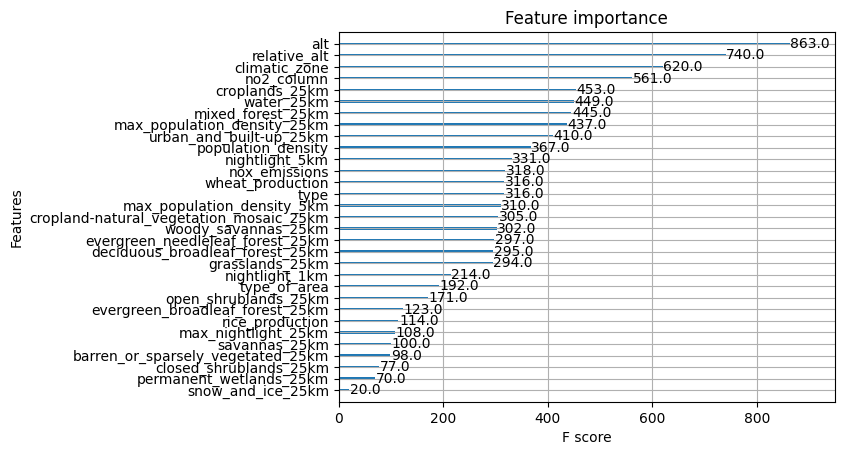

In [38]:
xgb.plot_importance(model_XGB_GS)

### Some Viz

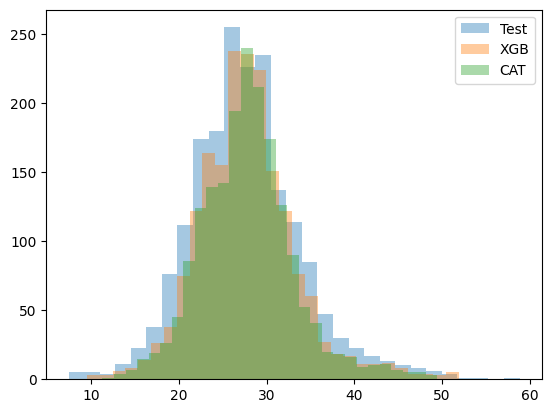

In [39]:
a = 0.4 # alpha
b = 29 # number of bins

plt.hist(y_test, alpha=a, bins=b, label='Test')
plt.hist(pred_XGB, alpha=a, bins = b, label='XGB')
plt.hist(pred_CAT, alpha=a, bins=b, label='CAT')

plt.legend()

Text(50.222222222222214, 0.5, 'y_Test')

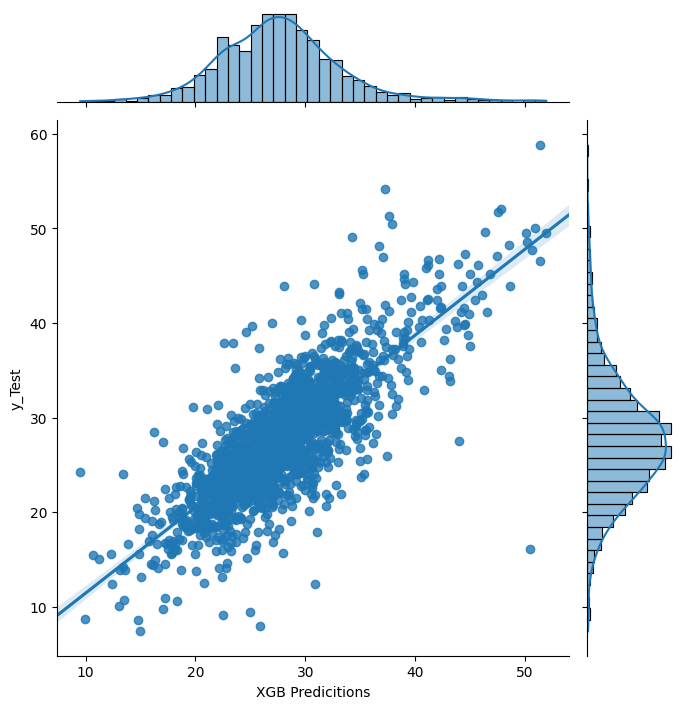

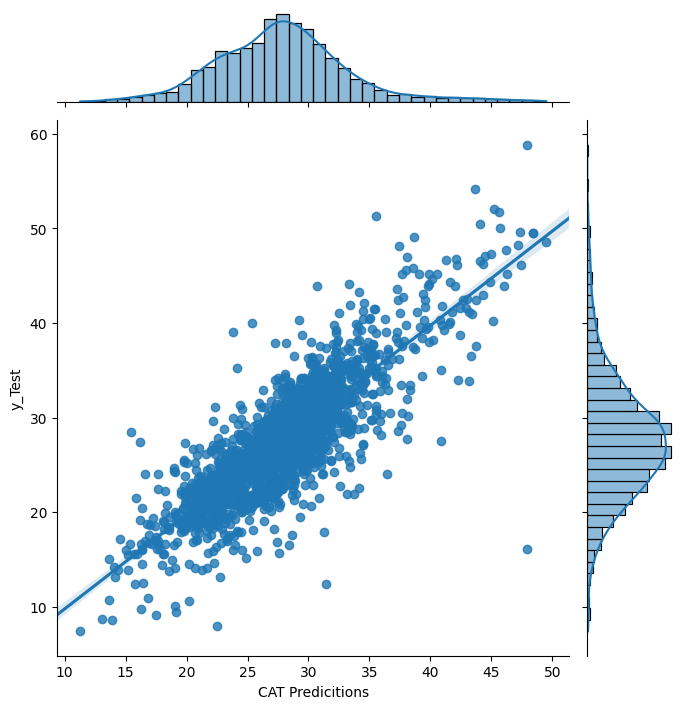

In [40]:
sns.jointplot(x=pred_XGB, 
              y=y_test, 
              kind="reg", truncate=False,
              height=7)

plt.xlabel('XGB Predicitions') 
plt.ylabel('y_Test') 

# plot 2
sns.jointplot(
            x=pred_CAT, 
            y=y_test, 
            kind="reg", truncate=False,
            height=7
              )

plt.xlabel('CAT Predicitions') 
plt.ylabel('y_Test')

# Summary

This code shows an example of an end-to-end machine learning workflow on tabular data. Is it not complete, as more time and energy should be spent on feature importance, engineering, and exploratoy data analysis. 

This was mainly developed to test GPU capabilities of Jetstream2. GPU's are not always needed for smaller datasets as this notebook shows. 